# Segmenting and Clustering Neighborhoods in Toronto
### Part 2

## Section 3.2 - Analysis and clustering

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import folium
from geopy.geocoders import Nominatim

### Load our work from part 1

In [2]:
path = os.path.join(os.path.abspath('../data'), 'TorontoVenues.csv')
venues_df = pd.read_csv(path)
venues_df.head()

Neighborhood  Neighborhood_lat  Neighborhood_long  \
0         Parkwoods         43.753259         -79.329656   
1         Parkwoods         43.753259         -79.329656   
2         Parkwoods         43.753259         -79.329656   
3  Victoria Village         43.725882         -79.315572   
4  Victoria Village         43.725882         -79.315572   

                    Venue                    Category  Venue_lat  Venue_long  
0         Brookbanks Park                        Park  43.751976  -79.332140  
1                Sun Life  Construction & Landscaping  43.754760  -79.332783  
2           Variety Store           Food & Drink Shop  43.751974  -79.333114  
3  Victoria Village Arena                Hockey Arena  43.723481  -79.315635  
4               Portugril       Portuguese Restaurant  43.725819  -79.312785

### We'll map our findings

First, we'll obtain the coordinates for Toronto. We'll treat the latitude and longitude as globals as we can use them later too

In [5]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent='Toronto_Explorer')
location = geolocator.geocode(address)
TORONTO_LAT = location.latitude
TORONTO_LONG = location.longitude
print(f'Geographical coordinates of Tornoto = {TORONTO_LAT}, {TORONTO_LONG}')

Geographical coordinates of Tornoto = 43.6534817, -79.3839347


Now we can map our neighborhoods, and venues. The neighborhoods will be blue geomarkers, and the venues will be red dots. Venue popups will contain name and category.

In [12]:
toronto_map = folium.Map(location=[TORONTO_LAT, TORONTO_LONG], zoom_start=11)

# Neighborhoods
for lat, long, label in zip(venues_df['Neighborhood_lat'], 
                            venues_df['Neighborhood_long'],
                            venues_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, long],
                  popup=label).add_to(toronto_map)
    
    
# Venues
for lat, long, venue, cat in zip(venues_df['Venue_lat'], 
                            venues_df['Venue_long'],
                            venues_df['Venue'],
                            venues_df['Category']):
    label = folium.Popup(f'{venue}, {cat}', parse_html=True)
    folium.CircleMarker([lat, long],
                         popup=label,
                         color='red',
                         fill=True,
                         radius=3).add_to(toronto_map)

    
toronto_map

### Calculate the proportions of venue categories in each neighborhood

One way to do this is to one_hot code the venue categories for each neighborhood. From that we can calculate what proportions of each type of venue is found in each neighborhood. 

In [13]:
# One hot encode the venue categories for each neighborhood
venues_onehot = pd.get_dummies(venues_df['Category'], prefix='', prefix_sep='')

# Add the neighborhood column to the new dataframe
venues_onehot['Neighborhood'] = venues_df['Neighborhood']

# Pandas added the new column alphabetically, so find out where it is and move it
# to be the first column
cols = list(venues_onehot.columns)
index = cols.index('Neighborhood')
fixed_columns = [venues_onehot.columns[index]] + cols[:index] + cols[index + 1:]
venues_onehot = venues_onehot[fixed_columns]

# Now we can calculate the proportions by getting the means of each category
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head()

Neighborhood  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0      0.0                 0.0           0.0             0.0              0.0   
1      0.0                 0.0           0.0             0.0              0.0   
2      0.0                 0.0           0.0             0.0              0.0   
3      0.0                 0.0           0.0             0.0              0.0   
4      0.0                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  ...  Trail  \
0               0.0             0.000000           0.0  ...    0.0   
1               0.0             0.000000           0.0  ...    0.0   
2               0.0             0.000000           0.0  ...    0.0   
3               0.0             0.000000           0.0  ...    0.0   
4               0.0             0.043478           0.0  ...    0.0   

   Train Station  Vegetarian / Vegan Restaurant  Video Game Store  \
0            0.0                            0.0               0.0   
1            0.0                            0.0               0.0   
2            0.0                            0.0               0.0   
3            0.0                            0.0               0.0   
4            0.0                            0.0               0.0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0                    0.0              0.0       0.0          0.0   
1                    0.0              0.0       0.0          0.0   
2                    0.0              0.0       0.0          0.0   
3                    0.0              0.0       0.0          0.0   
4                    0.0              0.0       0.0          0.0   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
4            0.0          0.0  

[5 rows x 272 columns]

If we sum all frequencies of venues for each neighborhood, is it aproximately 1? Just look at the first five to verify this assumption.

In [14]:
totals = []
for index, row in venues_grouped.iterrows():
    if index > 4:
        break
    totals.append({'Neighborhood': row['Neighborhood'],
                   'Sum': row[1:].sum()})
pd.DataFrame(totals)
    

Neighborhood  Sum
0                                        Agincourt  1.0
1                           Alderwood, Long Branch  1.0
2  Bathurst Manor, Wilson Heights, Downsview North  1.0
3                                  Bayview Village  1.0
4                Bedford Park, Lawrence Manor East  1.0

We can identify the top 10 venue types for each neighborhood. We will also include the significance of each of type, as its 'weight.' This is just the percentage of listed venue types for the neighborhood. It will also show categories that actually do not occur for a neighborhood with fewer venue types than num_venues.

We can adapt the function to generate the row with the top num_venues venue types along with their weights. As a dictionary it is simple to assemble them into a dataframe.

In [15]:
def mostCommon(row, num_venues):
    row_cats = row.iloc[1:]
    row_cats_sorted = row_cats.sort_values(ascending=False)
    row = {'Neighborhood': row.iloc[0]}
    for i in range(num_venues):
        row[f'Top_{i + 1}'] = row_cats_sorted.index[i]
        row[f'Weight_{i + 1}'] = round(row_cats_sorted[i], 2)
    return row

Assemble the dataframe

In [16]:
num_venues = 10
rows = []
for i in range(venues_grouped.shape[0]):
    rows.append(mostCommon(venues_grouped.iloc[i], num_venues))
top_venues = pd.DataFrame(rows)  

top_venues.head()     

Neighborhood                Top_1  \
0                                        Agincourt         Skating Rink   
1                           Alderwood, Long Branch          Pizza Place   
2  Bathurst Manor, Wilson Heights, Downsview North          Coffee Shop   
3                                  Bayview Village  Japanese Restaurant   
4                Bedford Park, Lawrence Manor East     Sushi Restaurant   

   Weight_1               Top_2  Weight_2           Top_3  Weight_3  \
0      0.25              Lounge      0.25  Breakfast Spot      0.25   
1      0.25        Skating Rink      0.12     Coffee Shop      0.12   
2      0.10                Bank      0.10  Ice Cream Shop      0.05   
3      0.25                Café      0.25            Bank      0.25   
4      0.09  Italian Restaurant      0.09     Coffee Shop      0.09   

                       Top_4  Weight_4               Top_5  ...  \
0  Latin American Restaurant      0.25  Mexican Restaurant  ...   
1                        Pub      0.12      Sandwich Place  ...   
2        Fried Chicken Joint      0.05  Chinese Restaurant  ...   
3         Chinese Restaurant      0.25               Motel  ...   
4             Sandwich Place      0.09             Butcher  ...   

                             Top_6 Weight_6                       Top_7  \
0  Molecular Gastronomy Restaurant     0.00  Modern European Restaurant   
1                         Pharmacy     0.12                         Gym   
2                      Bridal Shop     0.05                 Gas Station   
3              Moroccan Restaurant     0.00         Monument / Landmark   
4                  Thai Restaurant     0.04           Indian Restaurant   

  Weight_7                            Top_8 Weight_8  \
0     0.00                Mobile Phone Shop     0.00   
1     0.12                       Hobby Shop     0.00   
2     0.05                            Diner     0.05   
3     0.00  Molecular Gastronomy Restaurant     0.00   
4     0.04                             Café     0.04   

                        Top_9 Weight_9                     Top_10 Weight_10  
0          Miscellaneous Shop     0.00  Middle Eastern Restaurant      0.00  
1               Movie Theater     0.00                Men's Store      0.00  
2              Sandwich Place     0.05               Intersection      0.05  
3  Modern European Restaurant     0.00          Accessories Store      0.00  
4                  Restaurant     0.04                  Juice Bar      0.04  

[5 rows x 21 columns]

In [17]:
top_venues.shape

(95, 21)

## Clustering the neighborhoods by venue types

In [18]:
KCLUSTERS = 5

kmeans = KMeans(KCLUSTERS, random_state=42)
kmeans.fit(venues_grouped.drop(columns=['Neighborhood']))

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 3])

Not very compelling. Let's try an elbow plot to see if we can find an optimal value for K.

In [19]:
def calculate_scores(X, kmax):
    distortions = []
    for k in range(1, kmax+1):
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    return distortions

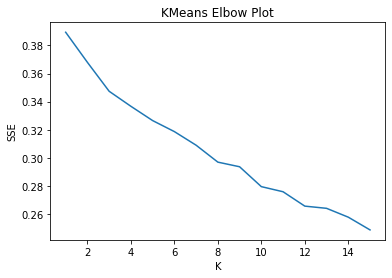

In [20]:
max_k = 15
sse = calculate_scores(venues_grouped.drop(columns=['Neighborhood']), max_k)

plt.plot(range(1, max_k + 1), sse)
plt.title('KMeans Elbow Plot')
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

It seems there is not an optimal level. As K gets higher, of course, it becomes closer to the number of neighborhhoods being segmented, and would become useless. Just trying K = 10.

In [23]:
KCLUSTERS = 10

kmeans = KMeans(KCLUSTERS, random_state=42)
kmeans.fit(venues_grouped.drop(columns=['Neighborhood']))

top_venues['Cluster'] = kmeans.labels_
new_columns = [top_venues.columns[-1]] + list(top_venues.columns[:-1])
top_venues = top_venues[new_columns]
top_venues.head()

Weight_10  Cluster                                     Neighborhood  \
0       0.00        1                                        Agincourt   
1       0.00        0                           Alderwood, Long Branch   
2       0.05        1  Bathurst Manor, Wilson Heights, Downsview North   
3       0.00        1                                  Bayview Village   
4       0.04        1                Bedford Park, Lawrence Manor East   

                 Top_1  Weight_1               Top_2  Weight_2  \
0         Skating Rink      0.25              Lounge      0.25   
1          Pizza Place      0.25        Skating Rink      0.12   
2          Coffee Shop      0.10                Bank      0.10   
3  Japanese Restaurant      0.25                Café      0.25   
4     Sushi Restaurant      0.09  Italian Restaurant      0.09   

            Top_3  Weight_3                      Top_4  ...  Weight_5  \
0  Breakfast Spot      0.25  Latin American Restaurant  ...      0.00   
1     Coffee Shop      0.12                        Pub  ...      0.12   
2  Ice Cream Shop      0.05        Fried Chicken Joint  ...      0.05   
3            Bank      0.25         Chinese Restaurant  ...      0.00   
4     Coffee Shop      0.09             Sandwich Place  ...      0.04   

                             Top_6  Weight_6                       Top_7  \
0  Molecular Gastronomy Restaurant      0.00  Modern European Restaurant   
1                         Pharmacy      0.12                         Gym   
2                      Bridal Shop      0.05                 Gas Station   
3              Moroccan Restaurant      0.00         Monument / Landmark   
4                  Thai Restaurant      0.04           Indian Restaurant   

   Weight_7                            Top_8  Weight_8  \
0      0.00                Mobile Phone Shop      0.00   
1      0.12                       Hobby Shop      0.00   
2      0.05                            Diner      0.05   
3      0.00  Molecular Gastronomy Restaurant      0.00   
4      0.04                             Café      0.04   

                        Top_9  Weight_9                     Top_10  
0          Miscellaneous Shop      0.00  Middle Eastern Restaurant  
1               Movie Theater      0.00                Men's Store  
2              Sandwich Place      0.05               Intersection  
3  Modern European Restaurant      0.00          Accessories Store  
4                  Restaurant      0.04                  Juice Bar  

[5 rows x 22 columns]

In [24]:
kmeans.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 7, 6, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 6,
       3, 1, 1, 0, 6, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 9, 1,
       2, 1, 1, 0, 0, 1, 2])

The neighborhoods are still not uniformally distributed into clusters. This means there would be little use so far in terms of comparisons, i.e., to determine similarities of neighborhoods based on the amenities they provide. I suspect this is a result of the highly sparse and dimensional data being clustered: combination of high dimensionality and high sparseness can cause the actual information to be treated more or less as noise by the algorithm. The non-zero values wind up being outliers.

In [34]:
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_map = folium.Map(location=[TORONTO_LAT, TORONTO_LONG], zoom_start=11)

colors_array = cm.rainbow(np.linspace(0, 1, KCLUSTERS))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for hood, cluster in zip(top_venues['Neighborhood'], top_venues['Cluster']):
    lat, long = (venues_df[venues_df['Neighborhood'] == hood]
                 [['Neighborhood_lat', 'Neighborhood_long']].iloc[0].values)
    label = folium.Popup(f'{hood}, cluster {cluster}', parse_html=True)
    folium.CircleMarker([lat, long],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster - 1],
                        fill=True).add_to(toronto_map)
    
toronto_map

### Display top venues by neighborhood, by cluster

In [45]:
from IPython.display import display

In [47]:
for cluster in range(KCLUSTERS):
    df = top_venues[top_venues['Cluster'] == cluster]
    print(f'Cluster {cluster}')
    display(df)
    

Cluster 0


Weight_10  Cluster                                       Neighborhood  \
1         0.0        0                             Alderwood, Long Branch   
69        0.0        0                      Runnymede, The Junction North   
71        0.0        0  South Steeles, Silverstone, Humbergate, Jamest...   
91        0.0        0                        Willowdale, Willowdale West   
92        0.0        0                                             Woburn   

            Top_1  Weight_1          Top_2  Weight_2                  Top_3  \
1     Pizza Place      0.25   Skating Rink      0.12            Coffee Shop   
69    Pizza Place      0.25  Grocery Store      0.25               Bus Line   
71  Grocery Store      0.20    Pizza Place      0.10    Fried Chicken Joint   
91    Pizza Place      0.20  Grocery Store      0.20                Butcher   
92    Coffee Shop      0.50       Pharmacy      0.25  Korean BBQ Restaurant   

    Weight_3                Top_4  ...  Weight_5                       Top_6  \
1       0.12                  Pub  ...      0.12                    Pharmacy   
69      0.25    Convenience Store  ...      0.00         Monument / Landmark   
71      0.10          Coffee Shop  ...      0.10              Sandwich Place   
91      0.20          Coffee Shop  ...      0.20                        Park   
92      0.25  Monument / Landmark  ...      0.00  Modern European Restaurant   

    Weight_6                            Top_7  Weight_7  \
1       0.12                              Gym      0.12   
69      0.00  Molecular Gastronomy Restaurant      0.00   
71      0.10             Fast Food Restaurant      0.10   
91      0.00                        Pet Store      0.00   
92      0.00                Mobile Phone Shop      0.00   

                         Top_8  Weight_8                      Top_9  Weight_9  \
1                   Hobby Shop       0.0              Movie Theater       0.0   
69  Modern European Restaurant       0.0          Mobile Phone Shop       0.0   
71                  Beer Store       0.1                   Pharmacy       0.1   
91              Massage Studio       0.0             Medical Center       0.0   
92          Miscellaneous Shop       0.0  Middle Eastern Restaurant       0.0   

                      Top_10  
1                Men's Store  
69        Miscellaneous Shop  
71                    Hostel  
91  Mediterranean Restaurant  
92        Mexican Restaurant  

[5 rows x 22 columns]

Cluster 1


Weight_10  Cluster                                     Neighborhood  \
0        0.00        1                                        Agincourt   
2        0.05        1  Bathurst Manor, Wilson Heights, Downsview North   
3        0.00        1                                  Bayview Village   
4        0.04        1                Bedford Park, Lawrence Manor East   
5        0.02        1                                      Berczy Park   
..        ...      ...                                              ...   
85       0.00        1                                 Victoria Village   
87       0.00        1                                        Westmount   
89       0.00        1                                Wexford, Maryvale   
90       0.03        1                      Willowdale, Willowdale East   
93       0.00        1                                 Woodbine Heights   

                        Top_1  Weight_1               Top_2  Weight_2  \
0                Skating Rink      0.25              Lounge      0.25   
2                 Coffee Shop      0.10                Bank      0.10   
3         Japanese Restaurant      0.25                Café      0.25   
4            Sushi Restaurant      0.09  Italian Restaurant      0.09   
5                 Coffee Shop      0.08              Bakery      0.05   
..                        ...       ...                 ...       ...   
85                Pizza Place      0.17        Intersection      0.17   
87                Pizza Place      0.17         Coffee Shop      0.17   
89  Middle Eastern Restaurant      0.17          Smoke Shop      0.17   
90           Ramen Restaurant      0.09         Pizza Place      0.06   
93               Skating Rink      0.17                Park      0.17   

                Top_3  Weight_3                      Top_4  ...  Weight_5  \
0      Breakfast Spot      0.25  Latin American Restaurant  ...      0.00   
2      Ice Cream Shop      0.05        Fried Chicken Joint  ...      0.05   
3                Bank      0.25         Chinese Restaurant  ...      0.00   
4         Coffee Shop      0.09             Sandwich Place  ...      0.04   
5        Cocktail Bar      0.05         Seafood Restaurant  ...      0.03   
..                ...       ...                        ...  ...       ...   
85  French Restaurant      0.17               Hockey Arena  ...      0.17   
87     Sandwich Place      0.17             Discount Store  ...      0.17   
89     Sandwich Place      0.17                Auto Garage  ...      0.17   
90               Café      0.06             Sandwich Place  ...      0.06   
93           Bus Stop      0.17         Athletics & Sports  ...      0.17   

                              Top_6  Weight_6                       Top_7  \
0   Molecular Gastronomy Restaurant      0.00  Modern European Restaurant   
2                       Bridal Shop      0.05                 Gas Station   
3               Moroccan Restaurant      0.00         Monument / Landmark   
4                   Thai Restaurant      0.04           Indian Restaurant   
5                          Pharmacy      0.03                    Beer Bar   
..                              ...       ...                         ...   
85            Portuguese Restaurant      0.17           Mobile Phone Shop   
87                     Intersection      0.17                Optical Shop   
89                           Bakery      0.17                 Men's Store   
90                 Sushi Restaurant      0.06                  Restaurant   
93                      Curling Ice      0.17   Middle Eastern Restaurant   

    Weight_7                            Top_8  Weight_8  \
0       0.00                Mobile Phone Shop      0.00   
2       0.05                            Diner      0.05   
3       0.00  Molecular Gastronomy Restaurant      0.00   
4       0.04                             Café      0.04   
5       0.03                      Cheese Shop      0.03   
..       ...          

Cluster 2


Weight_10  Cluster                                   Neighborhood Top_1  \
10        0.0        2                            Caledonia-Fairbanks  Park   
26        0.0        2  East Toronto, Broadview North (Old East York)  Park   
88        0.0        2                                         Weston  Park   
94        0.0        2                                York Mills West  Park   

    Weight_1              Top_2  Weight_2               Top_3  Weight_3  \
10      0.50      Women's Store      0.25                Pool      0.25   
26      0.67  Convenience Store      0.33   Accessories Store      0.00   
88      1.00  Accessories Store      0.00  Mexican Restaurant      0.00   
94      0.50  Convenience Store      0.50   Accessories Store      0.00   

                  Top_4  ...  Weight_5                            Top_6  \
10    Accessories Store  ...       0.0  Molecular Gastronomy Restaurant   
26   Mexican Restaurant  ...       0.0  Molecular Gastronomy Restaurant   
88  Monument / Landmark  ...       0.0       Modern European Restaurant   
94   Mexican Restaurant  ...       0.0  Molecular Gastronomy Restaurant   

    Weight_6                       Top_7  Weight_7               Top_8  \
10       0.0  Modern European Restaurant       0.0   Mobile Phone Shop   
26       0.0  Modern European Restaurant       0.0   Mobile Phone Shop   
88       0.0           Mobile Phone Shop       0.0  Miscellaneous Shop   
94       0.0  Modern European Restaurant       0.0   Mobile Phone Shop   

    Weight_8                      Top_9  Weight_9                     Top_10  
10       0.0         Miscellaneous Shop       0.0  Middle Eastern Restaurant  
26       0.0         Miscellaneous Shop       0.0  Middle Eastern Restaurant  
88       0.0  Middle Eastern Restaurant       0.0              Metro Station  
94       0.0         Miscellaneous Shop       0.0  Middle Eastern Restaurant  

[4 rows x 22 columns]

Cluster 3


Weight_10  Cluster Neighborhood   Top_1  Weight_1  \
66        0.0        3     Roselawn  Garden       1.0   

                        Top_2  Weight_2                Top_3  Weight_3  \
66  Middle Eastern Restaurant       0.0  Moroccan Restaurant       0.0   

                  Top_4  ...  Weight_5                       Top_6  Weight_6  \
66  Monument / Landmark  ...       0.0  Modern European Restaurant       0.0   

                Top_7  Weight_7               Top_8  Weight_8  \
66  Mobile Phone Shop       0.0  Miscellaneous Shop       0.0   

                 Top_9  Weight_9         Top_10  
66  Mexican Restaurant       0.0  Luggage Store  

[1 rows x 22 columns]

Cluster 4


Weight_10  Cluster                                       Neighborhood  \
39        0.0        4                                   Humberlea, Emery   
58        0.0        4  Old Mill South, King's Mill Park, Sunnylea, Hu...   

             Top_1  Weight_1              Top_2  Weight_2  \
39  Baseball Field       1.0  Accessories Store       0.0   
58  Baseball Field       1.0  Accessories Store       0.0   

                        Top_3  Weight_3                Top_4  ...  Weight_5  \
39  Middle Eastern Restaurant       0.0  Monument / Landmark  ...       0.0   
58  Middle Eastern Restaurant       0.0  Monument / Landmark  ...       0.0   

                         Top_6  Weight_6              Top_7  Weight_7  \
39  Modern European Restaurant       0.0  Mobile Phone Shop       0.0   
58  Modern European Restaurant       0.0  Mobile Phone Shop       0.0   

                 Top_8  Weight_8               Top_9  Weight_9         Top_10  
39  Miscellaneous Shop       0.0  Mexican Restaurant       0.0  Luggage Store  
58  Miscellaneous Shop       0.0  Mexican Restaurant       0.0  Luggage Store  

[2 rows x 22 columns]

Cluster 5


Weight_10  Cluster                                   Neighborhood  Top_1  \
81        0.0        5  The Kingsway, Montgomery Road, Old Mill North  River   

    Weight_1              Top_2  Weight_2                      Top_3  \
81       1.0  Accessories Store       0.0  Middle Eastern Restaurant   

    Weight_3                Top_4  ...  Weight_5                       Top_6  \
81       0.0  Monument / Landmark  ...       0.0  Modern European Restaurant   

    Weight_6              Top_7  Weight_7               Top_8  Weight_8  \
81       0.0  Mobile Phone Shop       0.0  Miscellaneous Shop       0.0   

                 Top_9  Weight_9 Top_10  
81  Mexican Restaurant       0.0  Motel  

[1 rows x 22 columns]

Cluster 6


Weight_10  Cluster                                       Neighborhood  \
50        0.0        6  Milliken, Agincourt North, Steeles East, L'Amo...   
65        0.0        6                                           Rosedale   
70        0.0        6                                Scarborough Village   

         Top_1  Weight_1              Top_2  Weight_2               Top_3  \
50  Playground      0.25               Park      0.25        Intersection   
65        Park      0.50              Trail      0.25          Playground   
70  Playground      1.00  Accessories Store      0.00  Mexican Restaurant   

    Weight_3                Top_4  ...  Weight_5                       Top_6  \
50      0.25  Arts & Crafts Store  ...       0.0          Miscellaneous Shop   
65      0.25    Accessories Store  ...       0.0  Modern European Restaurant   
70      0.00  Monument / Landmark  ...       0.0  Modern European Restaurant   

    Weight_6                Top_7  Weight_7                Top_8  Weight_8  \
50       0.0  Moroccan Restaurant       0.0  Monument / Landmark       0.0   
65       0.0    Mobile Phone Shop       0.0   Miscellaneous Shop       0.0   
70       0.0    Mobile Phone Shop       0.0   Miscellaneous Shop       0.0   

                              Top_9  Weight_9                      Top_10  
50  Molecular Gastronomy Restaurant       0.0  Modern European Restaurant  
65        Middle Eastern Restaurant       0.0          Mexican Restaurant  
70        Middle Eastern Restaurant       0.0               Metro Station  

[3 rows x 22 columns]

Cluster 7


Weight_10  Cluster    Neighborhood                 Top_1  Weight_1  \
49        0.0        7  Malvern, Rouge  Fast Food Restaurant       1.0   

                 Top_2  Weight_2                Top_3  Weight_3  \
49  Mexican Restaurant       0.0  Monument / Landmark       0.0   

                              Top_4  ...  Weight_5              Top_6  \
49  Molecular Gastronomy Restaurant  ...       0.0  Mobile Phone Shop   

    Weight_6               Top_7  Weight_7                      Top_8  \
49       0.0  Miscellaneous Shop       0.0  Middle Eastern Restaurant   

    Weight_8          Top_9  Weight_9           Top_10  
49       0.0  Metro Station       0.0  Harbor / Marina  

[1 rows x 22 columns]

Cluster 8


Weight_10  Cluster   Neighborhood        Top_1  Weight_1  Top_2  Weight_2  \
38        0.0        8  Humber Summit  Pizza Place       1.0  Motel       0.0   

                  Top_3  Weight_3           Top_4  ...  Weight_5  \
38  Martial Arts School       0.0  Massage Studio  ...       0.0   

                       Top_6  Weight_6        Top_7  Weight_7          Top_8  \
38  Mediterranean Restaurant       0.0  Men's Store       0.0  Metro Station   

    Weight_8               Top_9  Weight_9                     Top_10  
38       0.0  Mexican Restaurant       0.0  Middle Eastern Restaurant  

[1 rows x 22 columns]

Cluster 9


Weight_10  Cluster                                       Neighborhood  \
86        0.0        9  West Deane Park, Princess Gardens, Martin Grov...   

        Top_1  Weight_1   Top_2  Weight_2  Top_3  Weight_3  \
86  Gift Shop       0.5  Bakery       0.5  Motel       0.0   

                  Top_4  ...  Weight_5                       Top_6  Weight_6  \
86  Monument / Landmark  ...       0.0  Modern European Restaurant       0.0   

                Top_7  Weight_7               Top_8  Weight_8  \
86  Mobile Phone Shop       0.0  Miscellaneous Shop       0.0   

                        Top_9  Weight_9             Top_10  
86  Middle Eastern Restaurant       0.0  Accessories Store  

[1 rows x 22 columns]

Out of 95 neighborhoods with venues from Foursquare, 76 are clustered as cluster 1. This makes it less useful in segmenting neighborhoods by their amenities then we may like. A couple of ideas for improvement:

1) Exlpore other hyperparameters and/or other clustering alogorithms for highly dimensional/sparse data  
2) Explore dimensionality reduction strategies (e.g. PCA)  
3) We have a lot of venue categories that can be condensed -- e.g., instead of having many styles of restaraunts, group them all as just 'restaraunts.' The data is very thinned when we have many variations on a theme. E.g., 'Mexican Restuarant', 'American Restuarant', 'Molecular Gastronomy Restaurant' (that one must be one of a kind in the world?), etc. They can possibly be hierarchically clustered into more inclusive groups.

Below is a list of all the restaurant types, for example, and count of examples of each.

In [54]:
venues_df[venues_df['Category'].str.contains('Restaurant')]['Category'].value_counts()

Restaurant                         64
Italian Restaurant                 44
Japanese Restaurant                40
Sushi Restaurant                   32
Fast Food Restaurant               30
American Restaurant                26
Seafood Restaurant                 25
Thai Restaurant                    22
Vegetarian / Vegan Restaurant      18
Greek Restaurant                   15
Asian Restaurant                   14
Mexican Restaurant                 13
Chinese Restaurant                 13
Indian Restaurant                  12
Middle Eastern Restaurant          12
French Restaurant                  11
Vietnamese Restaurant              10
Caribbean Restaurant                8
Ramen Restaurant                    7
Comfort Food Restaurant             7
New American Restaurant             7
Mediterranean Restaurant            6
Latin American Restaurant           6
Gluten-free Restaurant              4
Eastern European Restaurant         3
Korean Restaurant                   3
Modern Europ